Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Import data

In [9]:
data = pd.read_csv('UoB_Set01_2025-01-31LOBs.csv')
print(data.head())

       Time        Bid1        Bid2         Ask1         Ask2  Mid-Price  \
0  07:30:00      [0, 0]      [0, 0]       [0, 0]       [0, 0]       0.00   
1  07:30:01  [325.0, 1]      [0, 0]       [0, 0]       [0, 0]     162.50   
2  07:30:02  [325.0, 4]  [292.0, 2]  [724.38, 8]  [800.0, 15]     524.69   
3  07:30:03  [325.0, 1]  [292.0, 1]   [713.0, 1]   [800.0, 5]     519.00   
4  07:30:04  [325.0, 1]  [292.0, 1]   [713.0, 1]   [800.0, 5]     519.00   

   Total_volume  Bid_ask_spread  Order_imbalance  
0             0            0.00             0.00  
1             1         -325.00             1.00  
2            29          399.38            -0.59  
3             8          388.00            -0.50  
4             8          388.00            -0.50  


Split the data 80:20 by time

In [23]:
# Calculate the split index
split_index = int(len(data) * 0.8)

# Split the DataFrame into train and test sets based on the split index
train = data.iloc[:split_index]
test = data.iloc[split_index:]

Do ADF Test to check if data is stationary 

In [42]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Bid_ask_spread'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[0] < result[4]["5%"]:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Fail to reject the null hypothesis - Data is not stationary")

ADF Statistic: -16.190346
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis - Data is stationary


Plot ACF

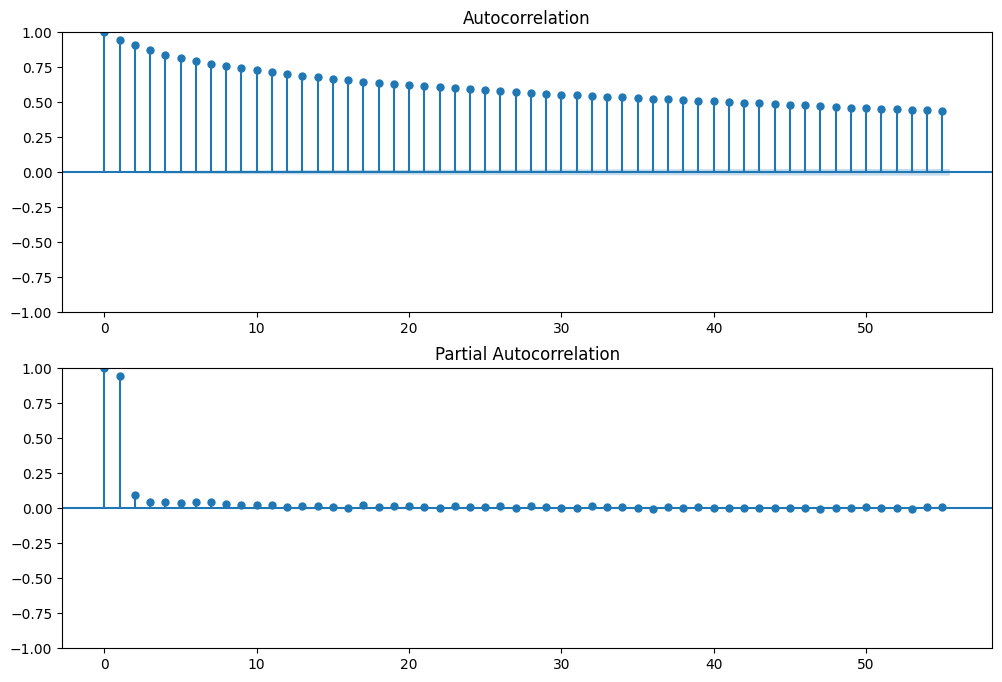

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Selecting the 'Mid-Price' column for ACF and PACF plots
train_mid_price = train['Bid_ask_spread]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_mid_price, ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(train_mid_price, ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Bid-Ask Spread ACF and PACF Plot interpretation


ACF Plot Interpretation

The ACF does not show a sharp cut-off but rather a gradual decline, suggesting that there may not be a need for MA terms, thus q should be 0.

PACF Plot Interpretation

The PACF shows a sharp cut-off after the first lag, which suggests that an AR term of order 1 might be appropriate. Therefore, p should be 1.

Differencing Term (d)

Data is stationary so d is 0.

Do ARIMA Test

In [43]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(train['Bid_ask_spread'], order=(1, 0, 0))  # Example order, adjust as necessary
model_fit = model.fit()
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Mid-Price   No. Observations:                24479
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -96058.709
Date:                Sat, 17 Feb 2024   AIC                         192125.417
Time:                        17:55:21   BIC                         192157.839
Sample:                             0   HQIC                        192135.922
                              - 24479                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        316.9477      0.420    754.988      0.000     316.125     317.770
ar.L1          0.7701      0.001    544.187      0.000       0.767       0.773
ma.L1          0.0968      0.002     42.444      0.0

Forecast the test set


In [44]:
# Forecast the length of the test values
arima_predicted = model_fit.forecast(steps=len(test))
predicted = arima_predicted.to_frame(name='Bid_ask_spread')

predicted.insert(0, 'Time', test['Time'])

print(type(predicted))
print(predicted)

<class 'pandas.core.frame.DataFrame'>
           Time   Mid-Price
24479  14:18:00  292.997512
24480  14:18:01  298.504029
24481  14:18:02  302.744513
24482  14:18:03  306.010044
24483  14:18:04  308.524778
...         ...         ...
30594  15:59:55  316.947690
30595  15:59:56  316.947690
30596  15:59:57  316.947690
30597  15:59:58  316.947690
30598  15:59:59  316.947690

[6120 rows x 2 columns]


Plot the predicted against the test

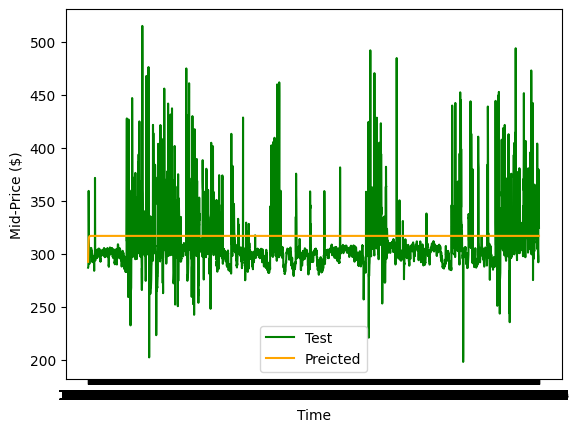

In [39]:
#plt.plot(train['Time'], train['Mid-Price'], label = 'Train')
plt.plot(test['Time'], test['Bid_ask_spread'], color = 'blue', label = 'Test')
plt.plot(predicted['Time'], predicted['Bid_ask_spread'], color = 'orange', label = 'Preicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bid_ask_spread')
plt.show()

Error Measurements

In [49]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['Bid_ask_spread'], predicted['Bid_ask_spread'])
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Bid_ask_spread'], predicted['Bid_ask_spread'])
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error
rmse = mean_squared_error(test['Bid_ask_spread'], predicted['Bid_ask_spread'], squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# R-squared
from sklearn.metrics import r2_score
r2 = r2_score(test['Bid_ask_spread'], predicted['Bid_ask_spread'])
print("R-squared:", r2)

Mean Absolute Error (MAE): 20.694582059757856
Mean Squared Error (MSE): 756.8680518694753
Root Mean Squared Error (RMSE): 27.51123501170886
R-squared: -0.09924785547627835


c:\Users\timot\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 10.306754469224506

The MAE tells you that, on average, your model's predictions are about 10.31 units away from the actual values. This is a direct measure of how accurate your model is, without considering the direction of the errors.


Mean Squared Error (MSE): 401.32652005997784

The MSE significantly higher than the MAE suggests that there are instances where the model's predictions are quite far from the actual values. This metric is sensitive to outliers, indicating your predictions might have some substantial errors in certain cases.


Root Mean Squared Error (RMSE): 20.03313555237866

The RMSE, like the MSE, is affected by outliers and large errors, and provides a sense of the average magnitude of the errors in the same units as your target variable. An RMSE of 20.03 means that the standard deviation of the prediction errors is around 20.03 units. 
This gives you an idea of the spread of the errors around the mean error (MAE).

R-squared: -0.19216190799522415

An R-squared value below 0 is quite rare and suggests that the model performs worse than a simple horizontal line representing the mean of the dependent variable. This negative value indicates that your model may not have captured any of the underlying trends in the data and is not explaining the variance in your target variable effectively.


Overall Interpretation:
The MAE and RMSE values indicate that the model has room for improvement in terms of accuracy. The large gap between MAE and RMSE suggests the presence of significant outliers or predictions far from the actual values.

The negative R-squared value is particularly concerning as it indicates the model's predictions do not align well with the actual data. It suggests that the model, in its current form, might not be suitable for your data or that the features you're using are not good predictors of the target variable.


Recommendations:
Review Model Features: Consider whether additional features or different representations of your current features could improve model performance.
Outlier Analysis: Examine your data for outliers that could be disproportionately influencing the model's errors.
Model Complexity: If your model is too simple, it might not capture complex patterns in the data. Conversely, if it's too complex, it might be overfitting. Adjusting model complexity could be a way to improve performance.
Cross-Validation: Use cross-validation to ensure that your model's performance is consistent across different subsets of your data.
Alternative Models: Explore different modeling techniques that might be more suited to your data's characteristics.